# Convolutional Neural Networks

## Write an Algorithm for a Dog Identification App 


---
### Introduction

This notebook serves the first steps towards developing an algorithm that could be used as part of a mobile or web app. The code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.  

![Sample Dog Output](images/sample_dog_output.png)

In this project, CNN models built from scratch as well as CNN models built by transfer learning are compared. 


---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

The first step is to import a dataset of dog images. The dataset contains 8351 dog images and there are 133 total dog categories.  

By using the `load_files` function from the scikit-learn library, the following variables are populated:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

A dataset of human images is imported. The dataset contains 13233 human images.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) can be used to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  The `haarcascades frontal face` detector is used here.

Number of faces detected: 1


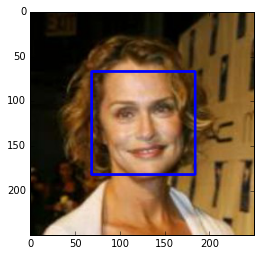

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

Using this procedure, a function can be written that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

By testing the face detector on the first 100 images `human_files` and `dog_files`, it is found that 98.00% of the first 100 images in `human_files` have a detected human face and 11.00% of the first 100 images in `dog_files` have a detected human face.   

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  The algorithm falls short of this goal, but still gives acceptable performance.  

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

# Test the performance of the face_detector algorithm 
# on the images in human_files_short and dog_files_short.
print('{:.2f}% of the first 100 images in `human_files` have a detected human face'\
      .format(sum([face_detector(p) for p in human_files_short])))
print('{:.2f}% of the first 100 images in `dog_files` have a detected human face'\
      .format(sum([face_detector(d) for d in dog_files_short])))

98.00% of the first 100 images in `human_files` have a detected human face
11.00% of the first 100 images in `dog_files` have a detected human face


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). But it is a reasonable expectation to pose on the users. The face detector we train should be able to accept images from different angles, lightings, and even with partial obscurations of the faces because those are probably more commonly uploaded by most users. We can build a face detector by including those different images in the training and validation dataset (we can get the images by collecting them or manually synthesizing them with clear images). We can build a deep leaning (CNN) model that detects these different faces.   

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model is used to detect dogs in images.  The ResNet-50 model along with weights that have been trained on [ImageNet](http://www.image-net.org/) is downloaded.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function [`preprocess_input`](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category. This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

The `dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
# returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

By testing the face detector on the first 100 images `human_files` and `dog_files`, we found that 1.00% of the images in `human_files_short` have a detected dog, and 100.00% of the images in `dog_files_short` have a detected dog. 

In [10]:
# Test the performance of the dog_detector function
# on the images in human_files_short and dog_files_short.
print('{:.2f}% of the images in `human_files_short` have a detected dog'\
      .format(sum(dog_detector(p) for p in human_files_short)))
print('{:.2f}% of the images in `dog_files_short` have a detected dog'\
      .format(sum(dog_detector(d) for d in dog_files_short)))

1.00% of the images in `human_files_short` have a detected dog
100.00% of the images in `dog_files_short` have a detected dog


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images. 


The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Also, random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:12<00:00, 69.15it/s]


### Model Architecture

A standard CNN architecture is designed to classify dog breed. It consists of 3 convolutional layers with spatial reduction via pooling. I also added batch normalization after each max pooling layer to boost the speed and increase accuracy. A fully connected layer is attached to the end of the network to make the final output predictions using learnings from the previous convolutional layers. The softmax activation used in this layer allows the output of probability for each breed. The model achieves a test accuracy around 4% with epoch of 5.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()

# Define your architecture.
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu', padding='same', \
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        18496     
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

In [16]:
from keras.callbacks import ModelCheckpoint  

epochs = 5

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 284s - loss: 4.7695 - acc: 0.0223 - val_loss: 4.8690 - val_acc: 0.0144
Epoch 2/5
6680/6680 [==============================] - 286s - loss: 4.6600 - acc: 0.0359 - val_loss: 4.6821 - val_acc: 0.0287
Epoch 3/5
6680/6680 [==============================] - 288s - loss: 4.5935 - acc: 0.0431 - val_loss: 4.6562 - val_acc: 0.0228
Epoch 4/5
6680/6680 [==============================] - 291s - loss: 4.5368 - acc: 0.0506 - val_loss: 4.5931 - val_acc: 0.0407
Epoch 5/5
6680/6680 [==============================] - 292s - loss: 4.4942 - acc: 0.0551 - val_loss: 4.6452 - val_acc: 0.0371


### Load the Model with the Best Validation Loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.9474%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we can train a CNN using transfer learning. 

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.2081 - acc: 0.1344 - val_loss: 10.5886 - val_acc: 0.2251
Epoch 2/20
6680/6680 [==============================] - 0s - loss: 9.9364 - acc: 0.2921 - val_loss: 9.8960 - val_acc: 0.2994
Epoch 3/20
6680/6680 [==============================] - 0s - loss: 9.4283 - acc: 0.3534 - val_loss: 9.6885 - val_acc: 0.2982
Epoch 4/20
6680/6680 [==============================] - 0s - loss: 9.0054 - acc: 0.3930 - val_loss: 9.2812 - val_acc: 0.3473
Epoch 5/20
6680/6680 [==============================] - 0s - loss: 8.6781 - acc: 0.4243 - val_loss: 9.1585 - val_acc: 0.3617
Epoch 6/20
6680/6680 [==============================] - 0s - loss: 8.5316 - acc: 0.4427 - val_loss: 8.9718 - val_acc: 0.3760
Epoch 7/20
6680/6680 [==============================] - 0s - loss: 8.3506 - acc: 0.4506 - val_loss: 8.8503 - val_acc: 0.3689
Epoch 8/20
6680/6680 [==============================] - 0s - loss: 8.1239 - 

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  A test accuracy around 46% is obtained with much shorter training time.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 46.7703%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In the last step, we used transfer learning to create a CNN using VGG-16 bottleneck features.  VGG-16's architecture was introduced by Simonyan and Zisserman in their 2014 paper, "Very Deep Convolutional Networks for Large Scale Image Recognition". This network is characterized by its simplicity. It uses only 3×3 convolutional layers stacked on top of each other in increasing depth. Reducing volume size is handled by max pooling. Two fully-connected layers, each with 4,096 nodes are then followed by a softmax classifier.

In this step, different bottleneck features are used, i.e., the ResNet-50 bottleneck features. ResNet-50 should work better because it is much deeper than VGG-16 and it solves the vanishing gradient problem while giving excellent performance.


### Obtain Bottleneck Features

The ResNet-50 bottleneck features are extracted corresponding to the train, test, and validation sets.

In [12]:
# Obtain bottleneck features from another pre-trained CNN.
bottleneck_features_2 = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet = bottleneck_features_2['train']
valid_Resnet = bottleneck_features_2['valid']
test_Resnet = bottleneck_features_2['test']

### Model Architecture

The model uses the the pre-trained ResNet-50 model as a fixed feature extractor, where the last convolutional output is fed as input to a global average pooling layer and then a fully connected layer. The fully connected layer contains one node for each dog category and is equipped with a softmax.

In [15]:
# Define architecture.
Resnet_model = Sequential()
Resnet_model.add(GlobalAveragePooling2D(input_shape=train_Resnet.shape[1:]))
Resnet_model.add(Dense(133, activation='softmax'))

Resnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [16]:
# Compile the model.
from keras.optimizers import Adam, Adamax
Resnet_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.0002), metrics=['accuracy'])

### Train the Model

In [18]:
from keras.callbacks import ModelCheckpoint  

In [19]:
# Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet.hdf5', 
                               verbose=1, save_best_only=True)

Resnet_model.fit(train_Resnet, train_targets, 
          validation_data=(valid_Resnet, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 4.4241 - acc: 0.0898 - val_loss: 3.8045 - val_acc: 0.1868
Epoch 2/20
6680/6680 [==============================] - 0s - loss: 3.3157 - acc: 0.3063 - val_loss: 3.0463 - val_acc: 0.3665
Epoch 3/20
6680/6680 [==============================] - 0s - loss: 2.6192 - acc: 0.4781 - val_loss: 2.4989 - val_acc: 0.5090
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 2.1130 - acc: 0.6033 - val_loss: 2.1027 - val_acc: 0.5940
Epoch 5/20
6680/6680 [==============================] - 0s - loss: 1.7425 - acc: 0.6897 - val_loss: 1.8124 - val_acc: 0.6419
Epoch 6/20
6680/6680 [==============================] - 0s - loss: 1.4700 - acc: 0.7403 - val_loss: 1.5972 - val_acc: 0.6874
Epoch 7/20
6680/6680 [==============================] - 0s - loss: 1.2637 - acc: 0.7810 - val_loss: 1.4371 - val_acc: 0.7102
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 1.1031 - ac

### Load the Model with the Best Validation Loss

In [20]:
# Load the model weights with the best validation loss.
Resnet_model.load_weights('saved_models/weights.best.Resnet.hdf5')

### Test the Model

With this model, the test accuracy reaches over 79%!

In [21]:
# Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet_predictions = [np.argmax(Resnet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet_predictions)==np.argmax(test_targets, axis=1))/len(Resnet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.1866%


### Predict Dog Breed with the Model

A function is written that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

The function first extract the bottleneck features and then supply the bottleneck features as input to the model to return the predicted vector. Finally, the `dog_names` array defined in Step 0 is used to return the corresponding breed.

In [25]:
# Write a function that takes a path to an image as input
# and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def Resnet_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path) == True:
        return print("The breed of dog is a {}".format(breed))
    else:
        return print("If this person were a dog, the breed would be a {}".format(breed))

---
<a id='step6'></a>
## Step 6: Write the Algorithm

An algorithm is written that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### Write the Algorithm

In [26]:
def predict_breed(img_path):
    isDog = dog_detector(img_path)
    isPerson = face_detector(img_path)
    if isDog:
        print("Detected a dog")
        breed = Resnet_predict_breed(img_path)
        return breed
    if isPerson:
        print("Detected a human face")
        breed = Resnet_predict_breed(img_path)
        return breed
    else:
        print("No human face or dog detected")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)

---
<a id='step7'></a>
## Step 7: Test the Algorithm


### Test the Algorithm on Sample Images!

The algorithm is used to test six images, three human and three dog images.  

The output is quite good. It correctly classified the three different dog breeds and for the three human images, the classifier made reasonable estimation of the resembling dog breed type. However, based on the accuracy scores, the current model performs much better on the training set than the test set, indicating an overfitting problem. In order to further improve the algorithm, we can optimize the model architecture by adding a dropout layer, or we can try to collect more data and train with a larger dataset. Also, the current model only works for images with one dog on it, it would be interesting to build multi-label models that works for images with more than one dog. 

Detected a dog
The breed of dog is a Afghan_hound


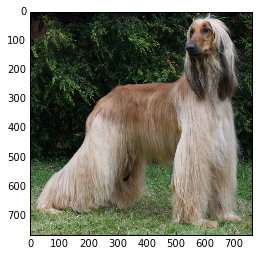

In [29]:
# test the algorithm
predict_breed('dogImages/train/002.Afghan_hound/Afghan_hound_00081.jpg')

Detected a dog
The breed of dog is a Brittany


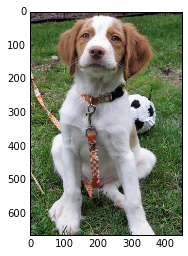

In [30]:
predict_breed('images/Brittany_02625.jpg')

Detected a dog
The breed of dog is a Labrador_retriever


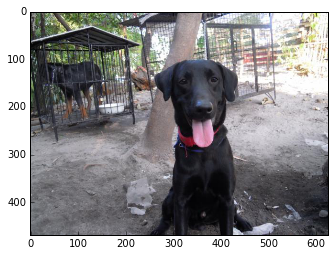

In [31]:
predict_breed('images/Labrador_retriever_06449.jpg')

Detected a human face
If this person were a dog, the breed would be a Chinese_crested


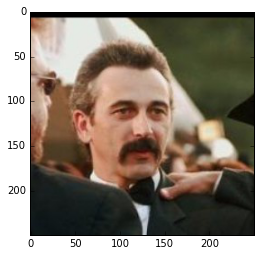

In [32]:
predict_breed('lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg')

Detected a human face
If this person were a dog, the breed would be a American_water_spaniel


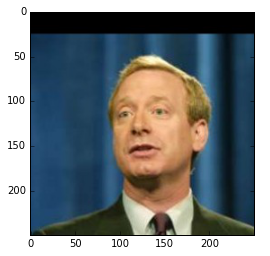

In [33]:
predict_breed('lfw/Brad_Smith/Brad_Smith_0001.jpg')

Detected a human face
If this person were a dog, the breed would be a Dachshund


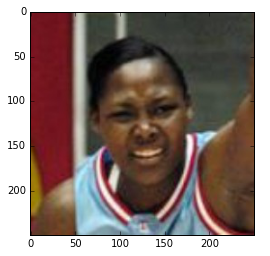

In [34]:
predict_breed('lfw/Cheryl_Ford/Cheryl_Ford_0001.jpg')